# ART calculations for `Yersinia Pestis` bacteria

In [10]:
import sys
import os

# Completely suppress stderr output
sys.stderr = open(os.devnull, 'w')

# Now import everything
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
sys.path.append('.')   # Add local directory to access some of the functions
sys.path.append('../../') # Make sure this is the location for the ART library

import warning_utils
warning_utils.filter_end_user_warnings()

In [11]:
import pandas as pd
import numpy as np

from art.core import RecommendationEngine
import art.utility as utils
import pickle
import cloudpickle
import matplotlib.pyplot as plt

### Define directories

In [12]:
dataDir = '/code/DTRA_ART/DrugDesignData/'
modelBuildingDataDir = os.path.join(dataDir, 'modelBuildingData/')
resultsDir = os.path.join(dataDir, 'Results/')
artResultDir = resultsDir + 'ART_results/YersiniaPestis/'
os.makedirs(artResultDir, exist_ok=True)
saveDir = os.path.join(resultsDir, "Yersinia_pestis/")
os.makedirs(saveDir, exist_ok=True)

### Extract the data for `Yersinia Pestis` into a data frame with `duplicate` SMILES

In [13]:
YersiniaPestisData_chEMBL_wMACAW = pd.read_csv(modelBuildingDataDir + "YersiniaPestisData_chEMBL_wMACAW.csv")
YersiniaPestisData_chEMBL_wMACAW 

,ID,compound_id,Smiles,pPotency,BacteriaClassifier,MACAW_1,MACAW_2,MACAW_3,MACAW_4,MACAW_5,MACAW_6,MACAW_7,MACAW_8,MACAW_9,MACAW_10,MACAW_11,MACAW_12,MACAW_13,MACAW_14,MACAW_15
0,1,CHEMBL2368935,CC(=O)NCCCC(=O)N[C@@H](Cc1ccccc1)C(=O)N1Cc2ccc...,3.707744,Yersinia_pestis,-0.489942,0.215019,-0.201604,0.199008,-0.078918,0.066663,-0.047755,0.014081,-0.020275,-0.011651,0.008476,-0.018348,0.007755,0.073672,0.007357
1,2,CHEMBL1255638,CC(=O)NCC(=O)N[C@@H](Cc1ccccc1)C(=O)N1Cc2ccccc...,3.657577,Yersinia_pestis,-0.490464,0.215795,-0.202575,0.199030,-0.080586,0.064377,-0.048941,0.014362,-0.021201,-0.011981,0.010391,-0.018487,0.008190,0.074091,0.008546
2,3,CHEMBL1255640,CC(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CCCCN)C(=O)N[...,4.882729,Yersinia_pestis,-0.490329,0.216233,-0.202777,0.198876,-0.079429,0.064345,-0.048978,0.014726,-0.022579,-0.012054,0.010283,-0.017066,0.009050,0.074586,0.008498
3,4,CHEMBL1255643,CC(C)C[C@H](NC(=O)[C@@H](N)CCCCN)C(=O)N1Cc2ccc...,3.823909,Yersinia_pestis,-0.490047,0.212706,-0.201936,0.201261,-0.082320,0.068193,-0.051442,0.016171,-0.023072,-0.009255,0.011218,-0.017050,0.006548,0.088113,0.008937
4,5,CHEMBL1200699,C[C@H]1c2cccc(O)c2C(=O)C2=C(O)[C@]3(O)C(=O)C(C...,6.251812,Yersinia_pestis,-0.010023,-0.041827,0.092784,-0.024684,0.135607,-0.002416,0.070988,0.068167,0.163430,-0.198643,0.072086,-0.048290,0.126874,-0.203575,-0.064221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,182,CHEMBL964,CCN(CC)C(=S)SSC(=S)N(CC)CC,4.494850,Yersinia_pestis,-0.103721,-0.356559,-0.074079,-0.053151,-0.012488,0.021213,0.022582,0.272578,0.172071,0.065805,0.199440,0.022153,-0.434164,-0.149058,-0.169882
149,183,CHEMBL4227290,CCCCCCCSSC(=S)N(CC)CC,4.494850,Yersinia_pestis,-0.117825,-0.486149,-0.141779,-0.157055,-0.040028,0.050134,-0.070543,-0.329781,-0.043124,-0.119243,-0.125223,0.121787,-0.008448,-0.102147,-0.050300
150,184,CHEMBL1255631,CC(=O)NCCCC(=O)N[C@@H](Cc1ccccc1)C(=O)N1Cc2ccc...,4.331614,Yersinia_pestis,-0.490263,0.215098,-0.200994,0.198897,-0.080130,0.066758,-0.048103,0.014189,-0.020352,-0.011351,0.008843,-0.018059,0.007592,0.075176,0.008536
151,186,CHEMBL1916867,CSC(=S)N/N=C/c1ccccc1O,5.397940,Yersinia_pestis,0.061029,-0.241608,0.204734,0.451870,-0.005429,-0.199036,0.058947,0.007172,-0.058368,-0.049119,-0.119836,0.081239,-0.049561,-0.063722,0.002679


### Prepare data to run `ART` on `Yersinia Pestis` data with `duplicate` SMILES

#### Find Features and Response

In [14]:
input_var = [col for col in YersiniaPestisData_chEMBL_wMACAW.columns if col.startswith('MACAW_')]
print(f"MACAW Embeddings: {len(input_var)}")
print(input_var)

MACAW Embeddings: 15
['MACAW_1', 'MACAW_2', 'MACAW_3', 'MACAW_4', 'MACAW_5', 'MACAW_6', 'MACAW_7', 'MACAW_8', 'MACAW_9', 'MACAW_10', 'MACAW_11', 'MACAW_12', 'MACAW_13', 'MACAW_14', 'MACAW_15']


In [15]:
features = YersiniaPestisData_chEMBL_wMACAW[input_var].to_numpy()

In [16]:
response_var = ["pPotency"]
print(response_var)

['pPotency']


In [17]:
response = YersiniaPestisData_chEMBL_wMACAW[response_var].to_numpy()

### save the data as a EDD style file

In [18]:
utils.save_edd_csv(features, response, input_var, modelBuildingDataDir + 'YersiniaPestisData_chEMBL_wMACAW_ARTready.csv', response_var)

### Predict response with ART

In [19]:
YersiniaPestisData_chEMBL_wMACAW_ARTready = pd.read_csv(modelBuildingDataDir + "YersiniaPestisData_chEMBL_wMACAW_ARTready.csv")
YersiniaPestisData_chEMBL_wMACAW_ARTready

,Line Name,Type,0.0
0,0,MACAW_1,-0.489942
1,1,MACAW_1,-0.490464
2,2,MACAW_1,-0.490329
3,3,MACAW_1,-0.490047
4,4,MACAW_1,-0.010023
...,...,...,...
2443,148,pPotency,4.494850
2444,149,pPotency,4.494850
2445,150,pPotency,4.331614
2446,151,pPotency,5.397940


### Define the ART parameters needed for the prediction

In [20]:
art_params = {
    'input_vars': input_var,
    'response_vars': response_var,
    'objective': 'maximize',
    'threshold': 0.2,
    'alpha': 0.5,
    'num_recommendations': 10,
    'max_mcmc_cores': 4,
    'seed': 42,                    
    'output_dir': artResultDir,
    'recommend': False,
    'cross_val': True,
    'num_tpot_models': 2,
}

### Run ART without recommendations but with cross-validations to gauge how generalizable the results are

ART identified 153 unique designs in the training data. 
Correctly communicating your designs is critical to building ART's model and to cross-validation.  We strongly suggest verifying ART's interpretation of your designs by inspecting the preprocessed DataFrame.  For example, if your ART instance is named `engine`, run `engine.df["Design"]`.  See Data Preparation docs for a description of how ART infers design information. https://lbl-biosci.gitlab.io/ese/art/Data_Preparation/#labeling-lines-designs-replicates-oh-my
is_classifier
is_classifier
is_classifier
is_classifier
is_regressor
is_regressor
is_regressor
is_regressor
is_classifier
is_classifier
is_classifier
is_classifier
is_regressor
is_regressor
is_regressor
is_regressor
is_classifier
is_classifier
is_classifier
is_classifier
is_regressor
is_regressor
is_regressor
is_regressor
is_classifier
is_classifier
is_classifier
is_classifier
is_regressor
is_regressor
is_regressor
is_regressor
is_classifier
is_classifier
is_classifier
is

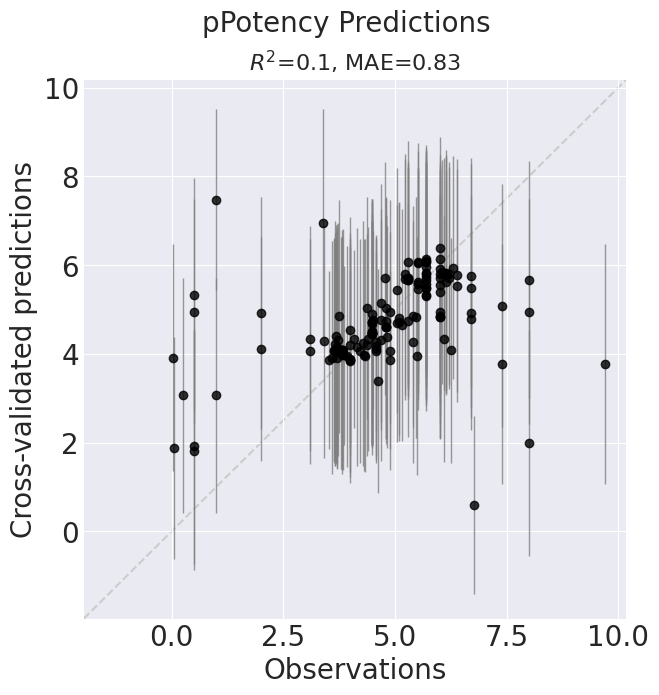

is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
i

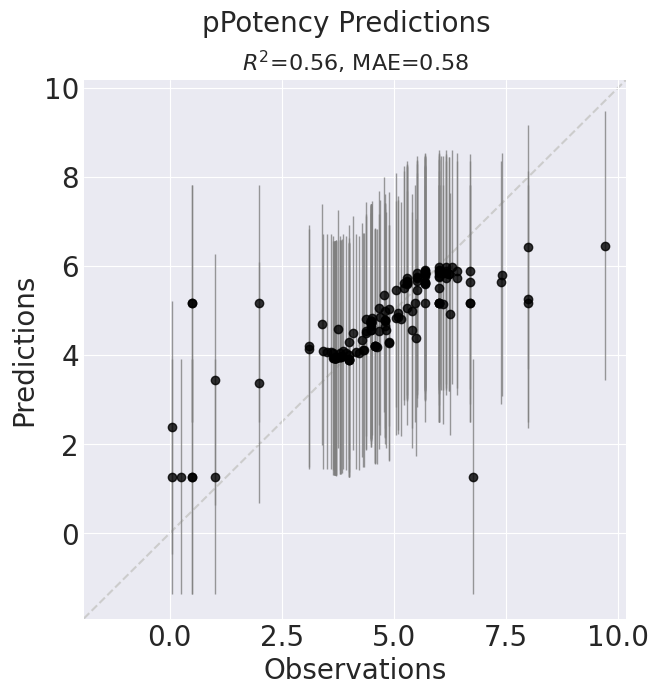

CPU times: user 3min 26s, sys: 1.56 s, total: 3min 28s
Wall time: 19min


In [21]:
%%time

art = RecommendationEngine(df=YersiniaPestisData_chEMBL_wMACAW_ARTready, **art_params)

In [ ]:
import shap
import matplotlib.pyplot as plt

### Find SHAP values

We will now find which input features are more important by using SHAP analysis. First, lets initialize the library:

In [ ]:
shap.initjs()

In [ ]:
plt.style.use('default')

define a wrapper function that provides the ART prediction given and input X, for use by the SHAP library

In [ ]:
def f(X):
    return art.predict(X)

convert the ART input data into the pandas dataframe that the SHAP library favors

In [ ]:
X_df = pd.DataFrame(data=art.X, columns=art_params['input_vars'])

create and execute the explainer for the features values

In [ ]:
explainer_e   = shap.Explainer(f, X_df)
shap_values_e = explainer_e(X_df)

In [ ]:
shap.summary_plot(shap_values_e)

In [ ]:
shap.plots.heatmap(shap_values_e, instance_order=shap_values_e.sum(1), max_display=15)


### Load pre-trained ART model (if necessary, otherwise skip this step)

In [ ]:
ARTtrainedModelFile = os.path.join(artResultDir, 'art.cpkl')
with open(ARTtrainedModelFile, 'rb') as f:
    art = cloudpickle.load(f)
print(f" ART model loaded from: {ARTtrainedModelFile}")

### Load MACAW transformer (not required at this moment)

## 2.1 Discovery of new hits specific to all bacteria (data source Enamine_antiviralsData.csv)

In this section, we screen a custom virtual library looking for molecules that are promising accoring to the the SVR models `regr` above, which use 15-D MACAW embeddings as their input. The custom library ("Enamine_antiviralsData.csv") compiled from commercial catalogs by Enamine. In particular, we are interested in molecules with high predicted pPotency.

Load MACAW embeedings for external validation data set

In [ ]:
YersiniaPestis_EnamineDatasets_wMACAW = pd.read_csv(saveDir + "YersiniaPestis_EnamineDataset_wMACAW.csv")
YersiniaPestis_EnamineDatasets_wMACAW

In [ ]:
macaw_columns = [col for col in YersiniaPestis_EnamineDatasets_wMACAW.columns if col.startswith('MACAW_')]
smi_lib_EnamineDatasets_wMACAW = YersiniaPestis_EnamineDatasets_wMACAW[macaw_columns].values

In [ ]:
Y1_lib_pred = art.predict(smi_lib_EnamineDatasets_wMACAW)
Y1_lib_pred

Get predictions with uncertainty using ART's post_pred_stats

In [ ]:
# Pass X1_lib (features)
mean, std = art.post_pred_stats(smi_lib_EnamineDatasets_wMACAW)

# Now use these for your results
EnamineAntiviralsData_predicted = YersiniaPestis_EnamineDatasets_wMACAW[['SMILES']].copy()
EnamineAntiviralsData_predicted['pPotency_prediction'] = mean
EnamineAntiviralsData_predicted['pPotency_std'] = std

# Calculate 95% Confidence Intervals
EnamineAntiviralsData_predicted['pPotency_lower_95CI'] = mean - 1.96 * std
EnamineAntiviralsData_predicted['pPotency_upper_95CI'] = mean + 1.96 * std

# Convert to IC50
EnamineAntiviralsData_predicted['IC50(M)_prediction'] = 10 ** (-mean)
EnamineAntiviralsData_predicted['IC50(M)_lower_95CI'] = 10 ** (-EnamineAntiviralsData_predicted['pPotency_upper_95CI'])
EnamineAntiviralsData_predicted['IC50(M)_upper_95CI'] = 10 ** (-EnamineAntiviralsData_predicted['pPotency_lower_95CI'])

# Select and save results
EnamineAntiviralsData_predicted = EnamineAntiviralsData_predicted.filter(
    items=["SMILES", "pPotency_prediction", "pPotency_std", 
           "pPotency_lower_95CI", "pPotency_upper_95CI",
           "IC50(M)_prediction", "IC50(M)_lower_95CI", "IC50(M)_upper_95CI"]
)

EnamineAntiviralsData_predicted.to_csv(os.path.join(saveDir + "YersiniaPestis_wART_EnamineDataset_predicted_all.csv"), index=False)
EnamineAntiviralsData_predicted[['SMILES']].to_csv(os.path.join(saveDir + "YersiniaPestis_wART_EnamineDataset_predicted_all_SMILES.csv"), index=False)
print(f"Predictions saved with uncertainty estimates")
EnamineAntiviralsData_predicted

## 2.2 Discovery of new hits specific to all bacteria (data source Life chemicals data set)

In this section, we screen a custom virtual library looking for molecules that are promising accoring to the the SVR models `regr` above, which use 15-D MACAW embeddings as their input. The custom library ("Enamine_antiviralsData.csv") compiled from commercial catalogs by Enamine. In particular, we are interested in molecules with high predicted pPotency.

In [ ]:
YersiniaPestis_LCAntiviralsData_wMACAW = pd.read_csv(saveDir + "YersiniaPestis_LCAntiviralsData_wMACAW.csv")
YersiniaPestis_LCAntiviralsData_wMACAW

In [ ]:
macaw_columns = [col for col in YersiniaPestis_LCAntiviralsData_wMACAW.columns if col.startswith('MACAW_')]
smi_lib_LCAntiviralsData_wMACAW = YersiniaPestis_LCAntiviralsData_wMACAW[macaw_columns].values

In [ ]:
Y1_lib_pred = art.predict(smi_lib_LCAntiviralsData_wMACAW)
Y1_lib_pred

Get predictions with uncertainty using ART's post_pred_stats

In [ ]:
# Pass X1_lib (features)
mean, std = art.post_pred_stats(smi_lib_LCAntiviralsData_wMACAW)

# Now use these for your results
LCAntiviralsData_predicted = YersiniaPestis_LCAntiviralsData_wMACAW[['SMILES']].copy()
LCAntiviralsData_predicted['pPotency_prediction'] = mean
LCAntiviralsData_predicted['pPotency_std'] = std

# Calculate 95% Confidence Intervals
LCAntiviralsData_predicted['pPotency_lower_95CI'] = mean - 1.96 * std
LCAntiviralsData_predicted['pPotency_upper_95CI'] = mean + 1.96 * std

# Convert to IC50
LCAntiviralsData_predicted['IC50(M)_prediction'] = 10 ** (-mean)
LCAntiviralsData_predicted['IC50(M)_lower_95CI'] = 10 ** (-LCAntiviralsData_predicted['pPotency_upper_95CI'])
LCAntiviralsData_predicted['IC50(M)_upper_95CI'] = 10 ** (-LCAntiviralsData_predicted['pPotency_lower_95CI'])

# Select and save results
LCAntiviralsData_predicted = LCAntiviralsData_predicted.filter(
    items=["SMILES", "pPotency_prediction", "pPotency_std", 
           "pPotency_lower_95CI", "pPotency_upper_95CI",
           "IC50(M)_prediction", "IC50(M)_lower_95CI", "IC50(M)_upper_95CI"]
)

LCAntiviralsData_predicted.to_csv(os.path.join(saveDir + "YersiniaPestis_wART_LCAntiviralsData_predicted_all.csv"), index=False)
LCAntiviralsData_predicted[['SMILES']].to_csv(os.path.join(saveDir + "YersiniaPestis_wART_LCAntiviralsData_predicted_all_SMILES.csv"), index=False)
print(f"Predictions saved with uncertainty estimates")
LCAntiviralsData_predicted

## 2.3 Discovery of new hits specific to all viruses (data source `chemDiv` data set)

In this section, we screen a custom virtual library looking for molecules that are promising accoring to the the SVR models `regr` above, which use 15-D MACAW embeddings as their input. The custom library compiled from commercial catalogs by Enamine. In particular, we are interested in molecules with high predicted pPotency.

In [ ]:
YersiniaPestis_ChemDivAntiviralsData_wMACAW = pd.read_csv(saveDir + "YersiniaPestis_ChemDivAntiviralsData_wMACAW.csv")
YersiniaPestis_ChemDivAntiviralsData_wMACAW

In [ ]:
macaw_columns = [col for col in YersiniaPestis_ChemDivAntiviralsData_wMACAW.columns if col.startswith('MACAW_')]
smi_lib_ChemDivAntiviralsData_wMACAW = YersiniaPestis_ChemDivAntiviralsData_wMACAW[macaw_columns].values

In [ ]:
Y1_lib_pred = art.predict(smi_lib_ChemDivAntiviralsData_wMACAW)
Y1_lib_pred

Get predictions with uncertainty using ART's post_pred_stats

In [ ]:
# Pass X1_lib (features)
mean, std = art.post_pred_stats(smi_lib_ChemDivAntiviralsData_wMACAW)

# Now use these for your results
ChemDivAntiviralsData_predicted = YersiniaPestis_ChemDivAntiviralsData_wMACAW[['SMILES']].copy()
ChemDivAntiviralsData_predicted['pPotency_prediction'] = mean
ChemDivAntiviralsData_predicted['pPotency_std'] = std

# Calculate 95% Confidence Intervals
ChemDivAntiviralsData_predicted['pPotency_lower_95CI'] = mean - 1.96 * std
ChemDivAntiviralsData_predicted['pPotency_upper_95CI'] = mean + 1.96 * std

# Convert to IC50
ChemDivAntiviralsData_predicted['IC50(M)_prediction'] = 10 ** (-mean)
ChemDivAntiviralsData_predicted['IC50(M)_lower_95CI'] = 10 ** (-ChemDivAntiviralsData_predicted['pPotency_upper_95CI'])
ChemDivAntiviralsData_predicted['IC50(M)_upper_95CI'] = 10 ** (-ChemDivAntiviralsData_predicted['pPotency_lower_95CI'])

# Select and save results
ChemDivAntiviralsData_predicted = ChemDivAntiviralsData_predicted.filter(
    items=["SMILES", "pPotency_prediction", "pPotency_std", 
           "pPotency_lower_95CI", "pPotency_upper_95CI",
           "IC50(M)_prediction", "IC50(M)_lower_95CI", "IC50(M)_upper_95CI"]
)

ChemDivAntiviralsData_predicted.to_csv(os.path.join(saveDir + "YersiniaPestis_wART_ChemDivAntiviralsData_predicted_all.csv"), index=False)
ChemDivAntiviralsData_predicted[['SMILES']].to_csv(os.path.join(saveDir + "YersiniaPestis_wART_ChemDivAntiviralsData_predicted_all_SMILES.csv"), index=False)
print(f"Predictions saved with uncertainty estimates")
ChemDivAntiviralsData_predicted

### 2.4 Checking drug likeliness of `Basidalin`

In [ ]:
YersiniaPestis_DTRA_target_antivirals_wMACAW = pd.read_csv(saveDir + "YersiniaPestis_DTRA_smiles_wMACAW.csv")
YersiniaPestis_DTRA_target_antivirals_wMACAW

In [ ]:
macaw_columns = [col for col in YersiniaPestis_DTRA_target_antivirals_wMACAW.columns if col.startswith('MACAW_')]
smi_lib_DTRA_target_antivirals_wMACAW = YersiniaPestis_DTRA_target_antivirals_wMACAW[macaw_columns].values

In [ ]:
Y1_lib_pred = art.predict(smi_lib_DTRA_target_antivirals_wMACAW)
Y1_lib_pred

Get predictions with uncertainty using ART's post_pred_stats

In [ ]:
# Pass X1_lib (features)
mean, std = art.post_pred_stats(smi_lib_DTRA_target_antivirals_wMACAW)

# Now use these for your results
DTRA_target_antivirals_predicted = YersiniaPestis_DTRA_target_antivirals_wMACAW[['SMILES']].copy()
DTRA_target_antivirals_predicted['pPotency_prediction'] = mean
DTRA_target_antivirals_predicted['pPotency_std'] = std

# Calculate 95% Confidence Intervals
DTRA_target_antivirals_predicted['pPotency_lower_95CI'] = mean - 1.96 * std
DTRA_target_antivirals_predicted['pPotency_upper_95CI'] = mean + 1.96 * std

# Convert to IC50
DTRA_target_antivirals_predicted['IC50(M)_prediction'] = 10 ** (-mean)
DTRA_target_antivirals_predicted['IC50(M)_lower_95CI'] = 10 ** (-DTRA_target_antivirals_predicted['pPotency_upper_95CI'])
DTRA_target_antivirals_predicted['IC50(M)_upper_95CI'] = 10 ** (-DTRA_target_antivirals_predicted['pPotency_lower_95CI'])

# Select and save results
DTRA_target_antivirals_predicted = DTRA_target_antivirals_predicted.filter(
    items=["SMILES", "pPotency_prediction", "pPotency_std", 
           "pPotency_lower_95CI", "pPotency_upper_95CI",
           "IC50(M)_prediction", "IC50(M)_lower_95CI", "IC50(M)_upper_95CI"]
)

DTRA_target_antivirals_predicted.to_csv(os.path.join(saveDir + "YersiniaPestis_wART_DTRA_target_antivirals_predicted_all.csv"), index=False)
DTRA_target_antivirals_predicted[['SMILES']].to_csv(os.path.join(saveDir + "YersiniaPestis_wART_DTRA_target_antivirals_predicted_all_SMILES.csv"), index=False)
print(f"Predictions saved with uncertainty estimates")
DTRA_target_antivirals_predicted

### Extract the data for `Yersinia Pestis` into a data frame without `duplicate` SMILES

### Prepare to run `ART` on `Yersinia Pestis` data without `duplicate` SMILES